In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
namesngenre = np.load('./dataset/namesngenre.npy')

In [3]:
namesngenre

array([['Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       ['Jumanji (1995)', 'Adventure|Children|Fantasy'],
       ['Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       ['Elsa & Fred (2005)', 'Comedy|Drama|Romance'],
       ['Tomb Raider (2018)', 'Action|Adventure|Fantasy'],
       ['Fred Armisen: Standup for Drummers (2018)', 'Comedy']],
      dtype='<U158')

In [4]:
ratings_train = np.load('./dataset/ratings_train.npy')

In [5]:
ratings_train.shape

(610, 4980)

In [6]:
ratings_train

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  2., nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [7]:
np.nanmax(ratings_train)

5.0

In [25]:
import MF
import importlib

# Reload a specific module
importlib.reload(MF)

<module 'MF' from 'c:\\Users\\User\\Documents\\Estudos\\M2 Dauphine\\Data Science Lab\\collaborativer_filter_user_recommendation\\collaborative_filter\\MF.py'>

In [36]:
k = 1

factorization = MF.MatrixFactorizarion(ratings_train, l=0.01, mu=0.01, k=k)


In [37]:
non_nan_indices = np.where(~np.isnan(ratings_train))
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = factorization.R[row_indices, col_indices]

In [38]:
factorization.fit(lr_I=0.0001, lr_U=0.0001, num_iterations=100)
prediction_full = factorization.predict()
prediction = prediction_full[row_indices, col_indices]
factorization.RMSE(prediction, R_non_nan)

Iteration 1: Cost = 37385635.98763281. RMSE = 1.0094347451678263
Iteration 2: Cost = 37407891.39533749. RMSE = 0.9934206324982349
Iteration 3: Cost = 37439158.16163504. RMSE = 0.9812283924284866
Iteration 4: Cost = 37475427.10047914. RMSE = 0.9713677471959667
Iteration 5: Cost = 37514284.12466538. RMSE = 0.963086893538922
Iteration 6: Cost = 37554211.11283908. RMSE = 0.9559582825264604
Iteration 7: Cost = 37594226.34213986. RMSE = 0.9497130614581516
Iteration 8: Cost = 37633685.45043247. RMSE = 0.9441689298042504
Iteration 9: Cost = 37672164.43478613. RMSE = 0.9391953970111917
Iteration 10: Cost = 37709387.47892058. RMSE = 0.9346953017348811
Iteration 11: Cost = 37745180.669356786. RMSE = 0.9305940977784246
Iteration 12: Cost = 37779441.34884099. RMSE = 0.9268332106774079
Iteration 13: Cost = 37812117.2704863. RMSE = 0.923365706035473
Iteration 14: Cost = 37843192.08993722. RMSE = 0.9201533557249199
Iteration 15: Cost = 37872675.07006737. RMSE = 0.9171645898424141
Iteration 16: Cost = 

0.8384479694393655

Obs.: The cost function may be leading to mistakes since it's taking into account the sparse values.

In [10]:
prediction_full = factorization.predict()

In [24]:
import time
import logging
from MF import MatrixFactorizarion 

# Initialize logging
logging.basicConfig(filename='mf_experiment.log', level=logging.INFO, format='%(asctime)s - %(message)s')

k_values = [1, 5, 10]

rmse_values = []
rmse_history = []

for k in k_values:
    start_time = time.time() 
    MF = MatrixFactorizarion(ratings_train, l=0.01, mu=0.01, k=k)
    MF.fit(lr_I=0.0001, lr_U=0.0001, num_iterations=10)
    
    prediction_full = MF.predict()
    prediction = prediction_full[row_indices, col_indices]
    
    rmse = MF.RMSE(prediction, R_non_nan)
    rmse_values.append(rmse)

    elapsed_time = time.time() - start_time
    
    # Log the results
    log_message = f'k={k}, RMSE={rmse}, Time={elapsed_time:.2f} seconds'
    logging.info(log_message)

# Plot RMSE evolution as a function of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o', linestyle='-')
plt.xlabel('Number of Factors (k)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Factors (k)')
plt.grid(True)
plt.show()



Iteration 1: Cost = 37385635.98763281. RMSE = 1.0094347451678263
Iteration 2: Cost = 37407891.39533749. RMSE = 0.9934206324982349
Iteration 3: Cost = 37439158.16163504. RMSE = 0.9812283924284866
Iteration 4: Cost = 37475427.10047914. RMSE = 0.9713677471959667
Iteration 5: Cost = 37514284.12466538. RMSE = 0.963086893538922
Iteration 6: Cost = 37554211.11283908. RMSE = 0.9559582825264604
Iteration 7: Cost = 37594226.34213986. RMSE = 0.9497130614581516
Iteration 8: Cost = 37633685.45043247. RMSE = 0.9441689298042504
Iteration 9: Cost = 37672164.43478613. RMSE = 0.9391953970111917
Iteration 10: Cost = 37709387.47892058. RMSE = 0.9346953017348811
Iteration 1: Cost = 37385635.987632826. RMSE = 1.0094347451678263
Iteration 2: Cost = 37407891.39533751. RMSE = 0.9934206324982349


KeyboardInterrupt: 

## Result analysis

__Attention:__ Here we pick only the non nan values, which returns a 1-D array. Then we reshape a part of them so we can see it as a image and visually comapre the results.

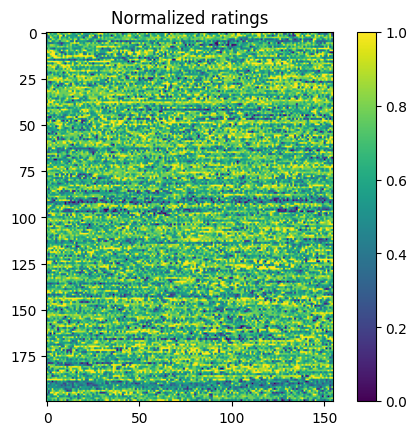

In [14]:
non_nan_indices = np.where(~np.isnan(ratings_train))
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = MF.R[row_indices, col_indices]
normalized_ratings = (R_non_nan - np.min(R_non_nan)) / (np.max(R_non_nan) - np.min(R_non_nan))
normalized_ratings = normalized_ratings[:normalized_ratings.shape[0]//1000 * 1000].reshape(200, -1)

# Create a heatmap using a colormap (e.g., 'viridis')
plt.imshow(normalized_ratings, cmap='viridis')
plt.colorbar()  # Add a colorbar for reference

# Show the heatmap
plt.title('Normalized ratings')
plt.show()


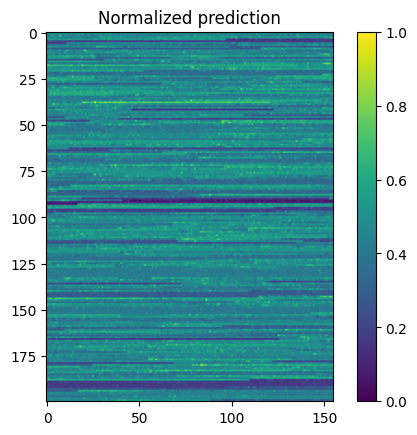

In [15]:
# Separate the row and column indices
row_indices, col_indices = non_nan_indices

# Access the corresponding values in the second matrix
prediction = prediction_full[row_indices, col_indices]
normalized_prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
normalized_prediction = normalized_prediction[:normalized_prediction.shape[0]//1000 * 1000].reshape(200, -1)
# Create a heatmap using a colormap (e.g., 'viridis')
plt.imshow(normalized_prediction, cmap='viridis')
plt.colorbar()  # Add a colorbar for reference

# Show the heatmap
plt.title('Normalized prediction')
plt.show()

In [16]:

MF.RMSE(prediction, R_non_nan)

0.90477980279857